In [27]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset 
import matplotlib.pyplot as plt

In [32]:
def accumulate_batch(images):
    return images.sum(dim=0)

In [54]:
# Define transformation for resizing and normalizing images
from concurrent.futures import ThreadPoolExecutor
import os 
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


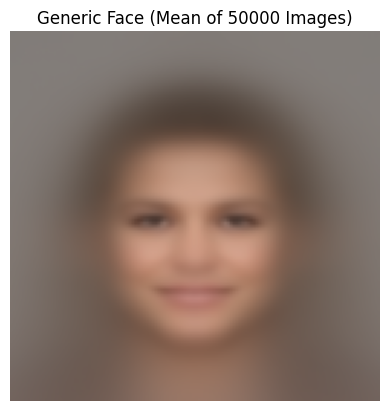

In [61]:
# Define transformation for resizing and normalizing images
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load the full dataset
dataset = datasets.ImageFolder(root="./img_align_celeba", transform=transform)

subset = Subset(dataset, range(50000))

# Define a collate function to move each batch to GPU
def collate_fn(batch):
    images, labels = zip(*batch)
    images = torch.stack(images).to(device)  # Stack images and move to GPU
    labels = torch.tensor(labels).to(device)  # Convert labels to tensor and move to GPU
    return images, labels

# Create DataLoader with the custom collate function
batch_size = 512  # Adjust based on your GPU memory
dataloader = DataLoader(subset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Initialize a tensor to accumulate pixel values
mean_face = torch.zeros(3, 128, 128, device=device, dtype=torch.float16)  # Use FP16
num_images = 0

for images, _ in dataloader:
    images = images.to(device, dtype=torch.float16)  # Move images to GPU and use FP16 
    mean_face += images.sum(dim=0)  # Accumulate pixel sums
    num_images += images.size(0)

# Compute the average (mean face) by dividing by the number of images
mean_face /= num_images

# Move the result back to CPU for visualization
mean_face_np = mean_face.to(dtype=torch.float32).permute(1, 2, 0).cpu().numpy()

# Plot the "average" face
plt.imshow(mean_face_np)
plt.axis('off')
plt.title(f'Generic Face (Mean of {num_images} Images)')
plt.show()